## 0. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# Get dataset
raw_images =  np.loadtxt('all_images_w_label.csv', delimiter=',', skiprows=0)

In [3]:
# Get features and labels
X, y = raw_images[:, :-1], raw_images[:, -1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

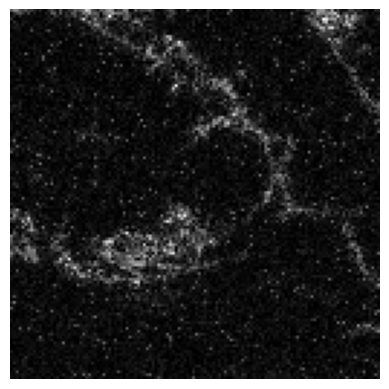

In [4]:
# Check image
image_2d = X_train[4000, :].reshape(128, 128)

# Display the image
plt.imshow(image_2d, cmap='gray')  
plt.axis('off') 
plt.show()

In [5]:
def edit_normalize_images(vectors):
    '''
    Edit normalize the microscope dataset
    '''
    out_vectors = np.copy(vectors)
    out_vectors[out_vectors < 20] = 0
    out_vectors[out_vectors != 0] = 1
    return out_vectors

In [6]:
X_train_1, X_test_1 = edit_normalize_images(X_train), edit_normalize_images(X_test)

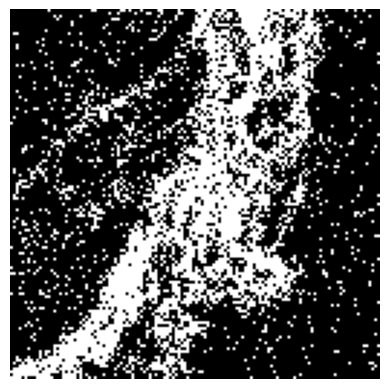

In [7]:
# Check image
image_2d = X_train_1[2000, :].reshape(128, 128)

# Display the image
plt.imshow(image_2d, cmap='gray')  
plt.axis('off') 
plt.show()

In [51]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [52]:
def edit_normalize_images_1(vectors):
    '''
    Edit normalize the microscope dataset
    '''
    out_vectors = np.copy(vectors)
    out_vectors[out_vectors < 0.5] = 0
    out_vectors[out_vectors != 0] = 1
    return out_vectors

In [53]:
X_train_scaled = edit_normalize_images_1(X_train_scaled)
X_test_scaled = edit_normalize_images_1(X_test_scaled)

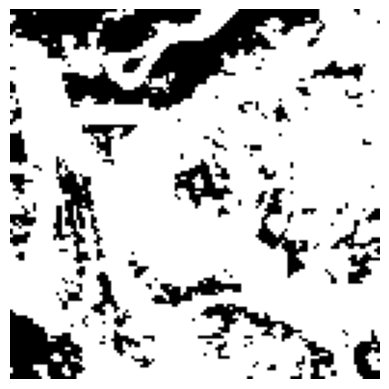

In [54]:
# Check image
image_2d = X_train_scaled[6000, :].reshape(128, 128)

# Display the image
plt.imshow(image_2d, cmap='gray')  
plt.axis('off') 
plt.show()

## 1. Apply HAAR to reduce dimensions

In [12]:
# Define HAAR functions

def get_sum_matrix(vectors, size):
    '''
    Construct summation matrices for microscope images (128*128)
    '''
    sum_mat = np.zeros(vectors.shape)
    sum_mat[:, 0, 0] = vectors[:, 0, 0]
    for i in range(1, size):
         sum_mat[:, i, 0] = sum_mat[:, i - 1, 0] + vectors[:, i, 0]
    for j in range(1, size):
         sum_mat[:, 0, j] = sum_mat[:, 0, j - 1] + vectors[:, 0, j]
    for i in range(1, size):
        for j in range(1, size):
            sum_mat[:, i, j] = (sum_mat[:, i - 1, j] + sum_mat[:, i, j - 1]
                                - sum_mat[:, i - 1, j - 1] + vectors[:, i, j])
    return sum_mat

def get_random_cut(size, cut_num, min_area = 1000):
    '''
    Randomly generate cut_num rectangles fitting inside the image box
    '''
    cut_mat = np.zeros(shape = (cut_num, 6, 2))
    for i in range(cut_num):
        adj_coord = np.zeros(shape = (2, 2))
        coord = np.random.randint(size, size = (2, 2))
        coord_diff = np.absolute(coord[0, :] - coord[1, :])
        while (np.multiply(coord_diff[0], coord_diff[1]) < min_area
               or np.sum(coord_diff % 2) != 0):
            coord = np.random.randint(size, size = (2, 2))
            coord_diff = np.absolute(coord[0, :] - coord[1, :])
        adj_coord[0, :] = np.min(coord, axis = 0)
        adj_coord[1, :] = np.max(coord, axis = 0)
        cut_mat[i][:2, :] = adj_coord
        cut_mat[i][2, 0] = (adj_coord[0, 0] + adj_coord[1, 0]) / 2
        cut_mat[i][2, 1] = adj_coord[1, 1]
        cut_mat[i][3, 0] = cut_mat[i][2, 0]
        cut_mat[i][3, 1] = adj_coord[0, 1]
        cut_mat[i][4, 0] = adj_coord[1, 0]
        cut_mat[i][4, 1] = (adj_coord[0, 1] + adj_coord[1, 1]) / 2
        cut_mat[i][5, 0] = adj_coord[0, 0]
        cut_mat[i][5, 1] = cut_mat[i][4, 1]
    cut_mat = cut_mat.astype(int)
    return cut_mat

def get_cut_area(sum_mat, coord):
    '''
    Compute the area of a generated rectangle inside the image box
    '''
    area_3 = sum_mat[:, coord[1, 0], coord[1, 1]]
    area_0 = sum_mat[:, coord[0, 0], coord[0, 1]]
    area_1 = sum_mat[:, coord[1, 0], coord[0, 1]]
    area_2 = sum_mat[:, coord[0, 0], coord[1, 1]]
    area = area_3 - area_1 - area_2 + area_0
    return area

def get_HARR_features(sum_mat, cut_mat):
    '''
    Get HAAR features for the microscope image dataset
    '''
    fea_mat = np.zeros(shape = (sum_mat.shape[0], cut_mat.shape[0] * 2))
    for i in range(cut_mat.shape[0]):
        fea_mat[:, i] = (get_cut_area(sum_mat, cut_mat[i][[0, 2], :]) -
                         get_cut_area(sum_mat, cut_mat[i][[3, 1], :]))
        j = i + cut_mat.shape[0]
        fea_mat[:, j] = (get_cut_area(sum_mat, cut_mat[i][[0, 4], :]) -
                         get_cut_area(sum_mat, cut_mat[i][[5, 1], :]))
    return fea_mat

## 3. Use logistic regression with L2 regularization
### 3.1. Run the model without normalization

In [49]:
# Edit normalize the microscope dataset 

X_train_final = X_train.reshape((X_train.shape[0], 128, 128))
X_test_final = X_test.reshape((X_test.shape[0], 128, 128))

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty="l2", solver="lbfgs", tol=1e0, max_iter=100000000000)

cut_mat = get_random_cut(128, 100, min_area=1000)
sum_mat_train = get_sum_matrix(X_train_final, 128)
sum_mat_test = get_sum_matrix(X_test_final, 128)
fea_mat_train = get_HARR_features(sum_mat_train, cut_mat)
fea_mat_test = get_HARR_features(sum_mat_test, cut_mat)

clf.fit(fea_mat_train, y_train)
score_harr = clf.score(fea_mat_test, y_test )

In [50]:
score_harr

0.6905555555555556

### 3.2. Run the model with normalization

In [57]:
# Edit normalize the microscope dataset 
X_train_final = X_train_scaled.reshape((X_train_scaled.shape[0], 128, 128))
X_test_final = X_test_scaled.reshape((X_test_scaled.shape[0], 128, 128))

clf = LogisticRegression(penalty="l2", solver="lbfgs", tol=1e0, max_iter=100000000000)

cut_mat = get_random_cut(128, 100, min_area=1000)
sum_mat_train = get_sum_matrix(X_train_final, 128)
sum_mat_test = get_sum_matrix(X_test_final, 128)
fea_mat_train = get_HARR_features(sum_mat_train, cut_mat)
fea_mat_test = get_HARR_features(sum_mat_test, cut_mat)

clf.fit(fea_mat_train, y_train)
score_harr = clf.score(fea_mat_test, y_test )

In [58]:
score_harr

0.71

## 4. Plot the high-dim image in 2-D and 3-D

In [65]:
from sklearn.manifold import TSNE

In [68]:
tsne_2_100 = TSNE(n_components=3, perplexity=100, learning_rate="auto", init="pca")
vectors_2_100 = tsne_2_100.fit_transform(fea_mat_train_1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [69]:
def plot_tsne(vectors, labels, colors_list, name, dim, perplexity,
              use_color_list = True):
    '''
    Plot data with a color per label
    '''
    if dim == 3:
        ax = plt.axes(projection = "3d")
        xdata, ydata, zdata = (vectors[:, 0], vectors[:, 1], vectors[:, 2])
        if use_color_list:
            colors = [colors_list[label] for label in labels]
            ax.scatter3D(xdata, ydata, zdata, c = colors, alpha = 0.5)
        else:
            ax.scatter3D(xdata, ydata, zdata, c = labels, alpha = 0.5)
        ax.set_title(f"{name} t_SNE data plot with perplexity = {perplexity}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    else:
        xdata, ydata = vectors[:, 0], vectors[:, 1]
        if use_color_list:
            colors = [colors_list[label] for label in labels]
            plt.scatter(xdata, ydata, c = colors, alpha = 0.5)
        else:
            plt.scatter(xdata, ydata, c = labels, alpha = 0.5)
        plt.title(f"{name} t_SNE data plot with perplexity = {perplexity}")
        plt.xlabel("x") 
        plt.ylabel("y")
    plt.show()

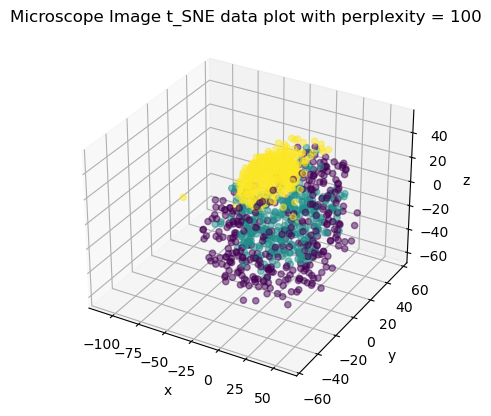

In [79]:
COLORS_LIST = ["blue", "orange", "green"]

plot_tsne(vectors_2_100[:1000], y_train[:1000], COLORS_LIST, "Microscope Image", 3, 100, False)

In [78]:
tsne_2_100_1 = TSNE(n_components=2, perplexity=100, learning_rate="auto", init="pca")
vectors_2_100_1 = tsne_2_100_1.fit_transform(fea_mat_train_1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


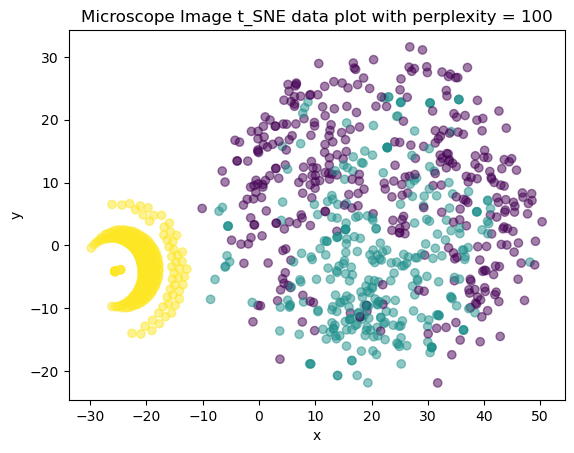

In [82]:
plot_tsne(vectors_2_100_1[:1000], y_train[:1000], COLORS_LIST, "Microscope Image", 2, 100, False)

## 5. Apply SVM to label the images
### 5.1. Use a linear kernel to classify

In [89]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM
# Initialize the SVM model
svm_model = SVC(kernel='linear', C=1.0)
# Fit the model on the training data
svm_model.fit(fea_mat_train_1, y_train)

# Evaluate the Model
# Predict on the test data
y_pred = svm_model.predict(fea_mat_test_1)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.44%


### 5.2. Use a nonlinear kernal

In [93]:
# Create an SVM classifier with the Gaussian kernel
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(fea_mat_train_1, y_train)

# Predict on the test data
y_pred = clf.predict(fea_mat_test_1)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.17%
